# Task: create model to detect employees, who are very likely to quit his position
Lets assume, that task was set by HR department and the purpose of this task is to avoid loosing employees. 
Also lets assume, that HR department is not afraid of FP (FalsePositive) results and will evaluate completeness of models predictions (in other words, they want a model wich would predict as many TP (TruePositive) as possible and will have as few FN (FalseNegative) as possible)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

df = pd.read_csv('/kaggle/input/hr-analytics/HR_comma_sep.csv')
df.shape

(14999, 10)

# EDA
## Quick look at dataset

In [2]:
# look at 5 random objects in the dataset to understand, what`s inside
df.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
4266,0.92,0.56,5,197,2,1,0,0,product_mng,medium
13907,0.73,0.94,3,177,3,0,0,0,technical,low
8851,0.54,0.88,4,170,4,0,0,0,RandD,low
12553,0.79,1.00,5,257,6,0,1,0,sales,low
6139,0.50,0.95,2,208,2,0,0,0,hr,low


In [3]:
# check data types and NaNs
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# check statistics of numeric features
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


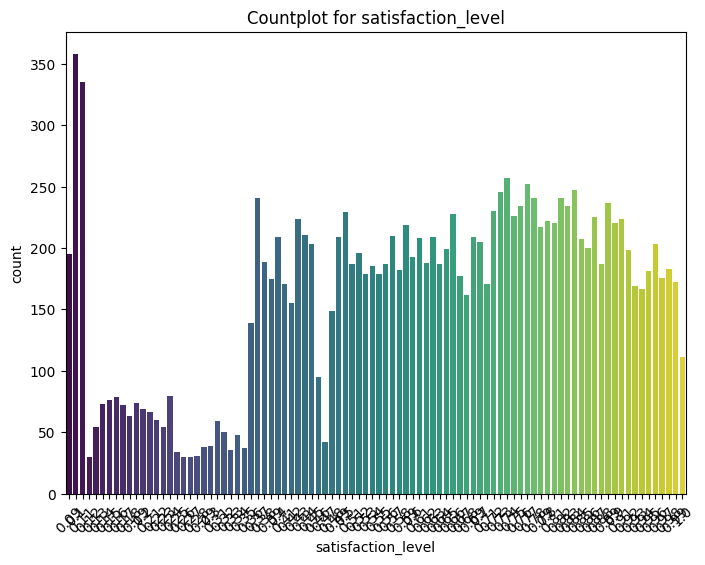

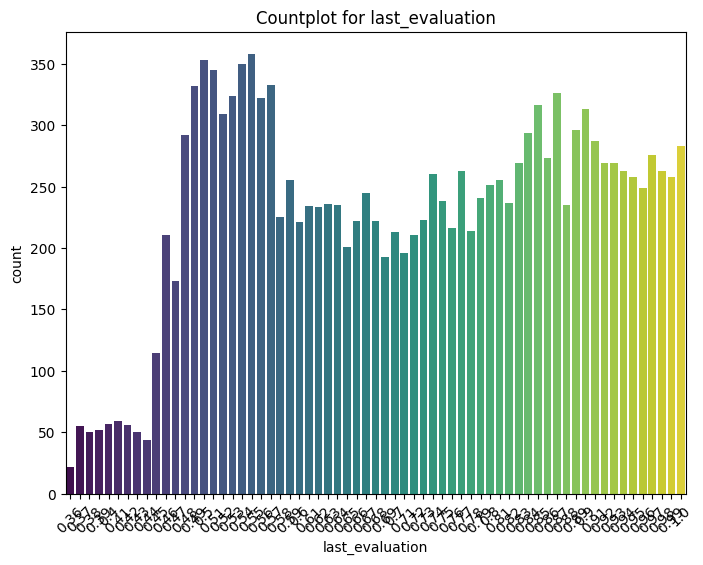

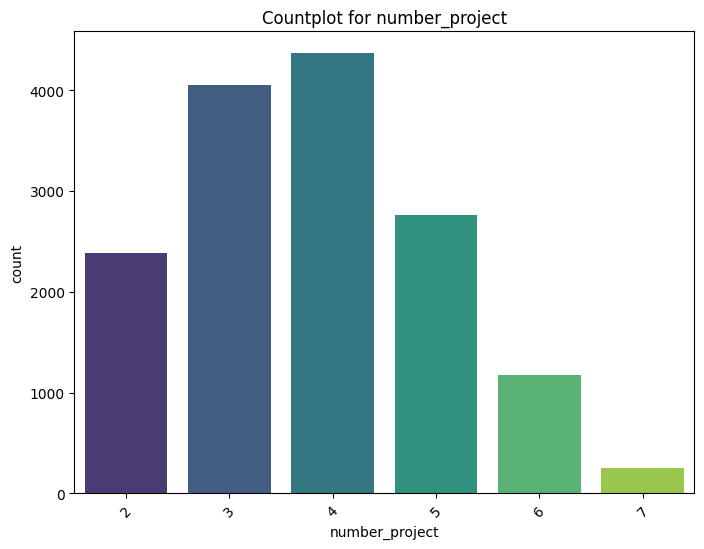

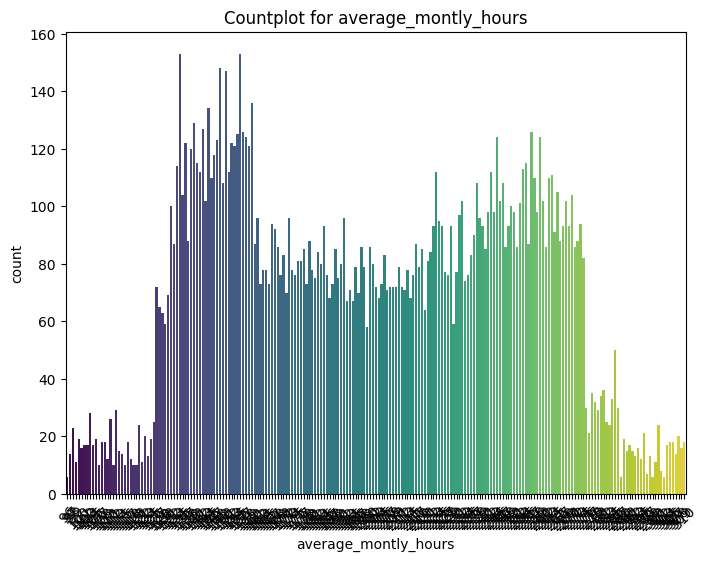

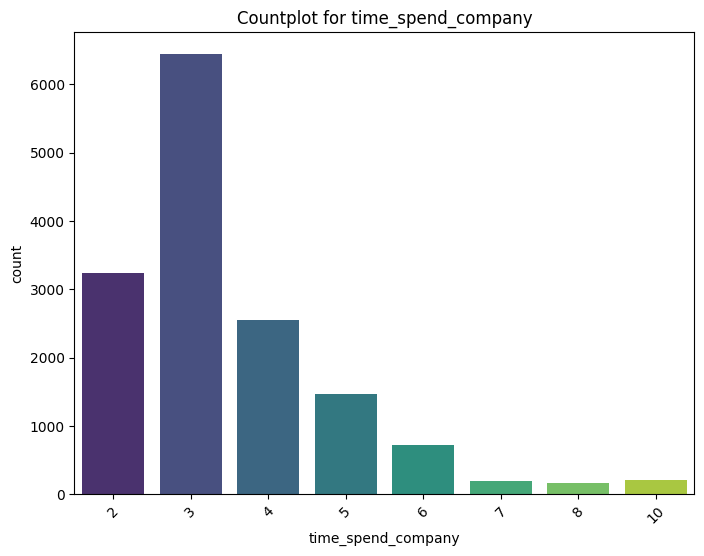

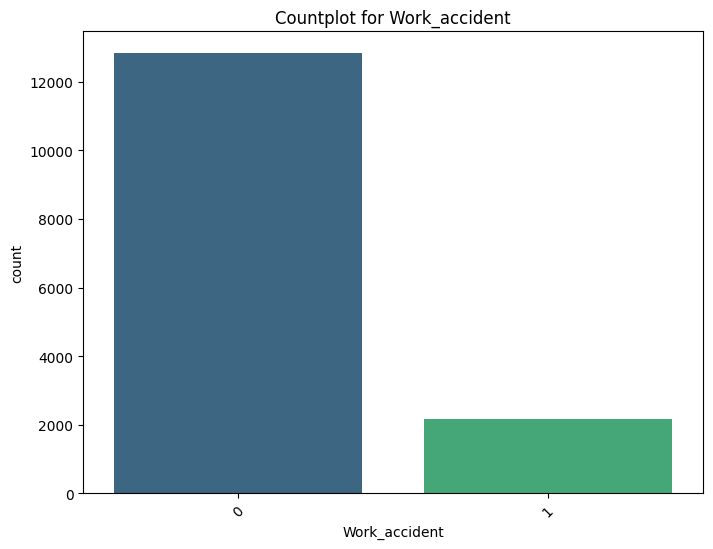

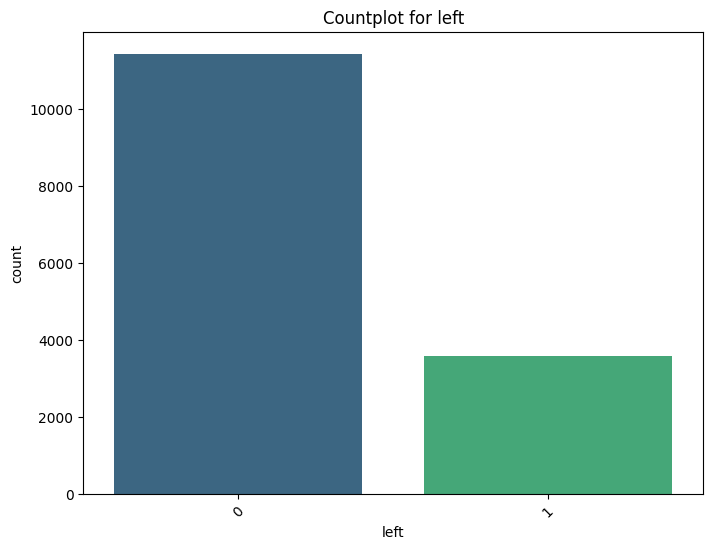

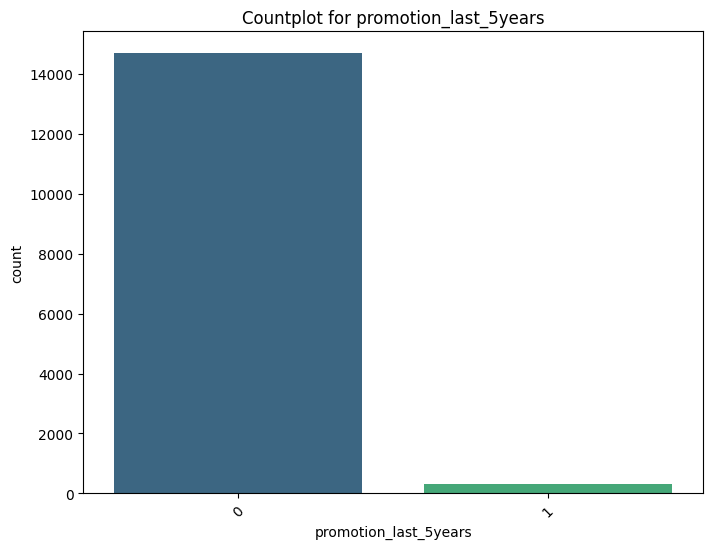

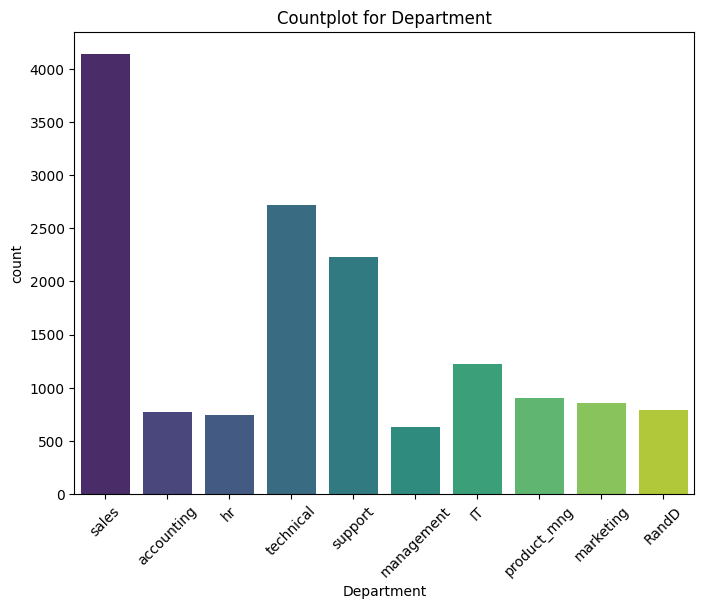

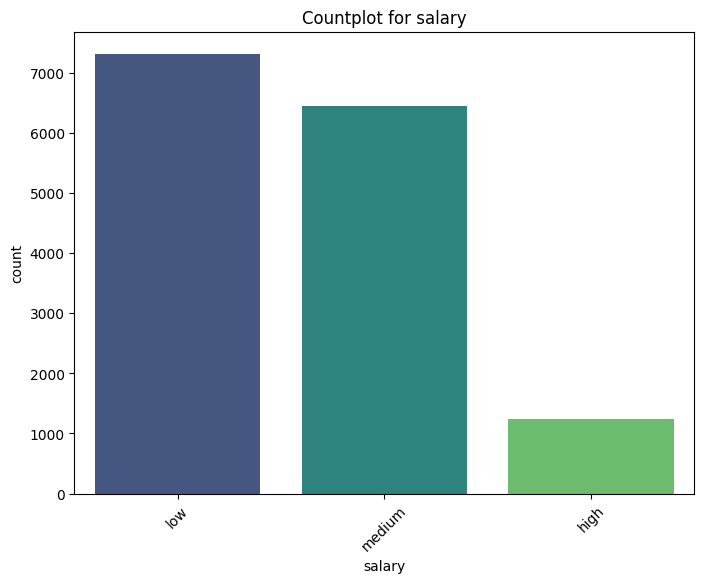

In [5]:
# see distributions of all features just by using countplot
for col in df.columns:
    plt.figure(figsize=(8, 6)) 
    sns.countplot(data=df, x=col, palette='viridis')  
    plt.title(f'Countplot for {col}')  
    plt.xticks(rotation=45)  
    plt.show()

## More precise look at categorical features

In [6]:
# check cardinality of 'Department' P.S.: it`s fine (10), we can use OHEncoder
df['Department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [7]:
# check values of 'salary' feature P.S.: LabelEncoder can be used, because it`s ordinal values
df['salary'].unique() 

array(['low', 'medium', 'high'], dtype=object)

In [8]:
# check cardinality of all features P.S.: all features with cardinality <= 10 are categorical (objects or discreet numeric values)
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                                         columns=['col_name', 'unique']).sort_values(by=['unique'])
unique_counts

,col_name,unique
5,Work_accident,2
6,left,2
7,promotion_last_5years,2
9,salary,3
2,number_project,6
4,time_spend_company,8
8,Department,10
1,last_evaluation,65
0,satisfaction_level,92
3,average_montly_hours,215


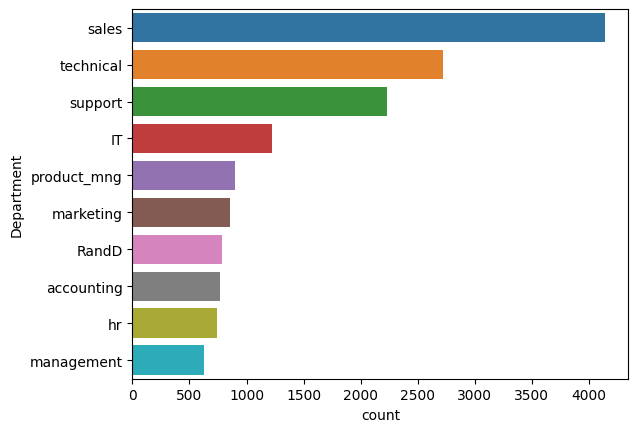

In [9]:
# check balance of 'Department'
%matplotlib inline
_ = sns.countplot(y='Department', data=df,orient='v', 
                   order=df['Department'].value_counts().index)

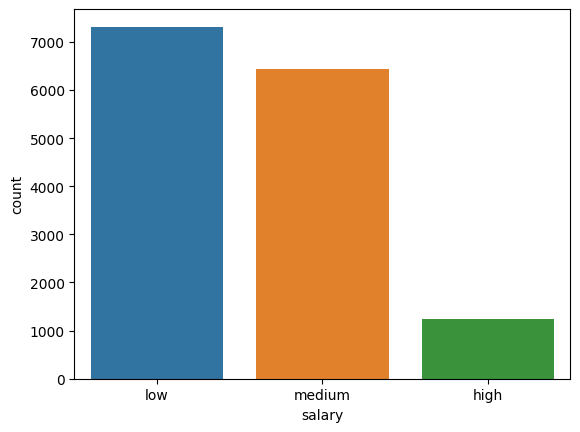

In [10]:
# check same for 'salary'
_ = sns.countplot(x='salary', data=df,orient='h', 
                   order=df['salary'].value_counts().index)

## Explore correlations between all features and target

In [11]:
# check correlation between 'Department' and 'left'
dep_dt = pd.crosstab(df['Department'], df['left'])
dep_dt['prcnt'] = dep_dt[1]/dep_dt[0]
dep_dt

left,0,1,prcnt
Department,,,
IT,954,273,0.286164
RandD,666,121,0.181682
accounting,563,204,0.362345
hr,524,215,0.410305
management,539,91,0.168831
marketing,655,203,0.309924
product_mng,704,198,0.281250
sales,3126,1014,0.324376
support,1674,555,0.331541


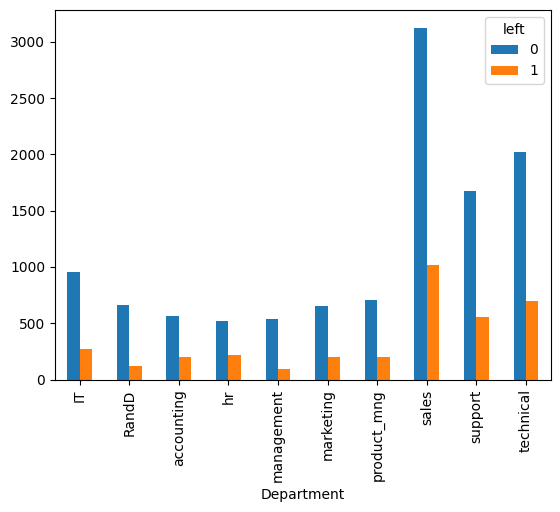

In [12]:
# visualize for better understanding
_ = pd.crosstab(df['Department'], df['left'], values=df['left'], aggfunc='count').plot(kind='bar')

In [13]:
# repeat same steps for 'salary'
sal_dt = pd.crosstab(df['salary'], df['left'])
sal_dt['prcnt'] = sal_dt[1]/sal_dt[0]
sal_dt

left,0,1,prcnt
salary,,,
high,1155,82,0.070996
low,5144,2172,0.422240
medium,5129,1317,0.256775


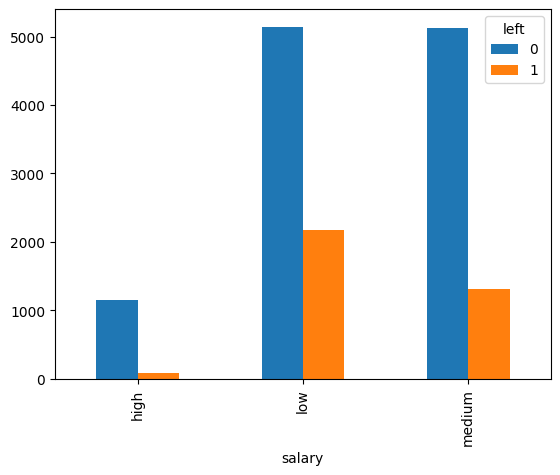

In [14]:
_ = pd.crosstab(df['salary'], df['left'], values=df['salary'], aggfunc='count').plot(kind='bar')

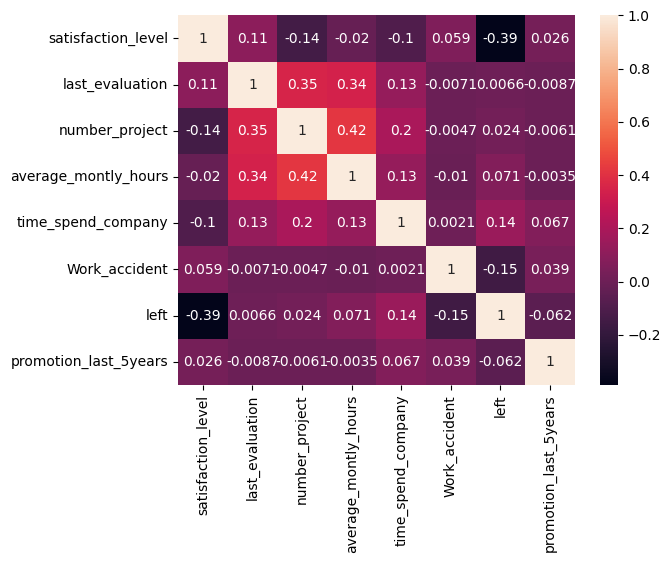

In [15]:
# check correlations between all numeric features and target P.S.: great, none of features have too strong correlations
_ = sns.heatmap(df.corr(numeric_only=True), annot=True)

In [16]:
# just for general knowledge lets check insights about employees
new_df = df.drop(['Department', 'salary'], axis=1)
new_df.groupby('left').agg(pd.Series.mean)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


Interesting, employees, who left the company had more projects, more average monthly hours and much less work accidents, but, on average, were less promoted in last 5 years than employees who didn`t left the company

# Preprocessing
## Deal with categorical features

In [17]:
# hardcode of LabelEncoder for salary (to keep correct ordinality)
df['salary'].replace(['high', 'medium', 'low'], [3, 2, 1], inplace=True)

In [18]:
# just for safety fillna in 'Department' with 'RandD' and script to replace new possible values
df['Department'].fillna('RandD', inplace=True)

known_deps = ['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD']
df['Department'] = df['Department'].apply(lambda x: x if x in known_deps else 'RandD') 

In [19]:
# encode 'Department' with OHEncoder and convert column names to str 
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['Department']]).toarray())
final_df = df.join(encoder_df)
final_df.columns = final_df.columns.astype(str)
final_df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,0,1,2,3,4,5,6,7,8,9
0,0.38,0.53,2,157,3,0,1,0,sales,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.80,0.86,5,262,6,0,1,0,sales,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.11,0.88,7,272,4,0,1,0,sales,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.72,0.87,5,223,5,0,1,0,sales,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.37,0.52,2,159,3,0,1,0,sales,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14995,0.37,0.48,2,160,3,0,1,0,support,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14996,0.37,0.53,2,143,3,0,1,0,support,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14997,0.11,0.96,6,280,4,0,1,0,support,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# drop original 'Department' and 9th column (there is enough data in cols 0-8)
final_df.drop(['Department', '9'], axis=1 ,inplace=True)

## Deal with numerical features
Unluckly distribution of features 'satisfaction_level', 'last_evaluation' and 'avetage_monthly_hours' is close to uniform, there is nothing we can do to make them closer to normal and it is not that bad. The only feature wich is close to normal and can be fitted to normal distribution is 'number_project', but it is discreet and i don`t think that it can really affect perfomance of our model
(btw it can be done using log())

## Split dataset
Optimal sizes for train-val-test is 0.8-0.1-0.1 (because we got almost 15k objects)

In [21]:
X = final_df
y = X.pop('left')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0, stratify=y_test)

## Scaling
It is important to note that scaling has to be done after splitting dataset into train-val-test
If we use MinMaxScaler() from sklearn, first of all we have to use fit_transform() for train and transform() for val and test

In [22]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Model_1_17
First of all, lets try to train model with 1 dense layer with 17 neurons (=amount of features)

In [23]:
inputs = tf.keras.layers.Input(shape=X_train.shape[1], name='input')
x_1 = tf.keras.layers.Dense(units=17, activation='relu', kernel_regularizer='l2') (inputs)
output = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output') (x_1)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 17)                306       
                                                                 
 output (Dense)              (None, 1)                 18        
                                                                 
Total params: 324
Trainable params: 324
Non-trainable params: 0
_________________________________________________________________


In [24]:
# create 2 callbacks: 1-for early stopping, 2-checkpoint for best weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=0,#1,
    mode="auto",
    restore_best_weights=True,
)
filepath = 'checkpoints/model_{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor="val_loss",
    verbose=0,#1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=1.
)

In [25]:
# compile the model with lr=0.005, as loss we will use binary_crossentropy and as metrics we want to see Recall
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005), 
    loss=tf.keras.losses.binary_crossentropy, 
    metrics=[tf.keras.metrics.Recall()]
)

## Train model_1_17

In [26]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size=X_train.shape[0],
    epochs=1000,
    callbacks=[checkpoint, early_stopping],
    validation_data=(X_val, y_val),
    shuffle=False,
    steps_per_epoch=1,
    validation_steps=1,
    validation_batch_size=X_val.shape[0],
    workers=10,
    use_multiprocessing=True,
    verbose=0#1,
)

## Evaluation model_1_17

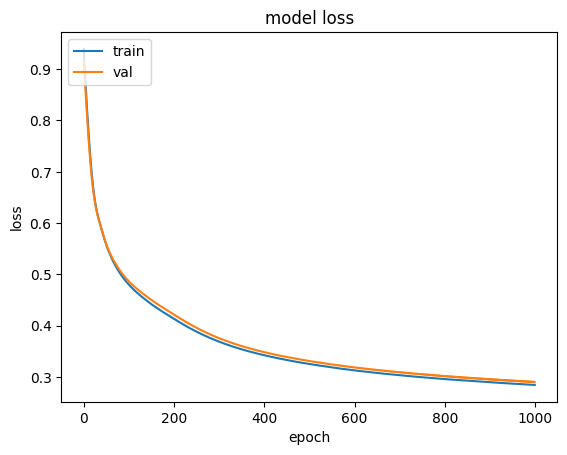

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As we see from loss graphic, loss of model didn`t reach its minimum and we have to increase amount of epochs
## Anyway, lets evaluate this model
Based on our formulation of the task, the model can be evaluated using Recall_1 or F_β-score (note: for this task β has to be greater than 1, thus Recall would make more impact in this metric

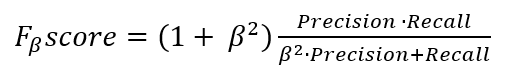

In [28]:
# make predictions
y_pred_raw = model.predict(X_test)

47/47 [==============================] - 0s 1ms/step


In [29]:
# round predictions of model 
y_pred = np.around(y_pred_raw)

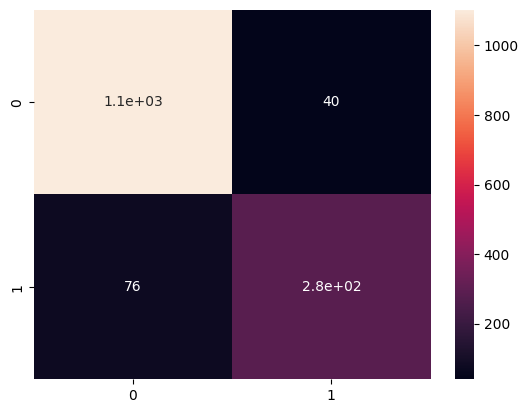

In [30]:
# visualize confuzion_matrix with heatmap
_ = sns.heatmap(confusion_matrix(y_test, y_pred),annot=True) # только stratify, 1 скрытый слой, 17 нейронов

In [31]:
# also lets check metrics of model (we are interested in Recall_1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1143
           1       0.88      0.79      0.83       357

    accuracy                           0.92      1500
   macro avg       0.91      0.88      0.89      1500
weighted avg       0.92      0.92      0.92      1500



## Try same model but with more epochs

In [32]:
# compile the same model but with 5000 epochs
inputs = tf.keras.layers.Input(shape=X_train.shape[1], name='input')
x_1 = tf.keras.layers.Dense(units=17, activation='relu', kernel_regularizer='l2') (inputs)
output = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output') (x_1)

model2 = tf.keras.Model(inputs=inputs, outputs=output)

model2.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005), 
    loss=tf.keras.losses.binary_crossentropy, 
    metrics=[tf.keras.metrics.Recall()]
)

early_stopping2 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=0,#1,
    mode="auto",
    restore_best_weights=True,
)
filepath = 'checkpoints/model_{epoch:02d}-{val_loss:.2f}.h5'
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor="val_loss",
    verbose=0,#1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=1.
)

history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size=X_train.shape[0],
    epochs=5000,
    callbacks=[checkpoint2, early_stopping2],
    validation_data=(X_val, y_val),
    shuffle=False,
    steps_per_epoch=1,
    validation_steps=1,
    validation_batch_size=X_val.shape[0],
    workers=10,
    use_multiprocessing=True,
    verbose=0#1
)

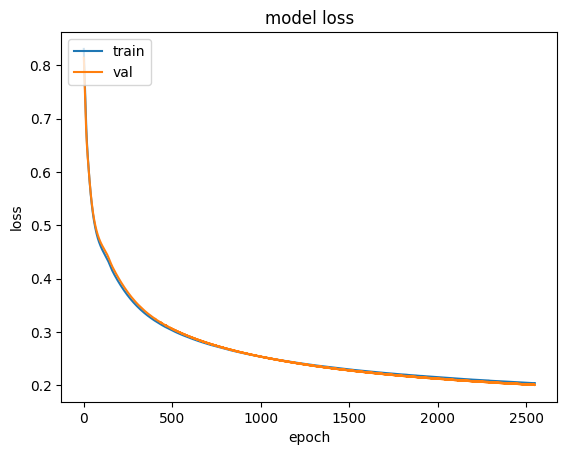

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
# make predictions and evaluate model (using Recall_1)
y_pred_raw = model2.predict(X_test)
y_pred = np.around(y_pred_raw)
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1143
           1       0.91      0.91      0.91       357

    accuracy                           0.96      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.96      0.96      0.96      1500



## Try to improve perfomance
There are different ways, how we can improve perfomance of the model, the most obvious - try to make our dataset balanced by target variable
To make dataset balanced we can:
* Cut off objects from class 0 (not preferred)
* Supplement with objects from class 1
* Copy and past existing objects from class 1 (not preferred)

So, lets try to make dataset balanced using SMOTE() and see the impact

In [35]:
# for the purity of the experiment lets apply SMOTE only to train and val and keep test with existing distribution 
X_train_sm, y_train_sm = SMOTE().fit_resample(X_train, y_train)
X_val_sm, y_val_sm = SMOTE().fit_resample(X_val, y_val)

In [36]:
# create and train same model with 5000 epochs
inputs = tf.keras.layers.Input(shape=X_train.shape[1], name='input')
x_1 = tf.keras.layers.Dense(units=17, activation='relu', kernel_regularizer='l2') (inputs)
output = tf.keras.layers.Dense(units=1, activation='sigmoid', name='output') (x_1)

model3 = tf.keras.Model(inputs=inputs, outputs=output)
model3.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.005), 
    loss=tf.keras.losses.binary_crossentropy, 
    metrics=[tf.keras.metrics.Recall()]
)

early_stopping3 = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=0,#1,
    mode="auto",
    restore_best_weights=True,
)
filepath = 'checkpoints/model_{epoch:02d}-{val_loss:.2f}.h5'
checkpoint3 = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor="val_loss",
    verbose=0,#1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=1.
)

history = model3.fit(
    x = X_train_sm,
    y = y_train_sm,
    batch_size=X_train_sm.shape[0],
    epochs=5000,
    callbacks=[checkpoint3, early_stopping3],
    validation_data=(X_val_sm, y_val_sm),
    shuffle=False,
    steps_per_epoch=1,
    validation_steps=1,
    validation_batch_size=X_val_sm.shape[0],
    workers=10,
    use_multiprocessing=True,
    verbose=0#1
)

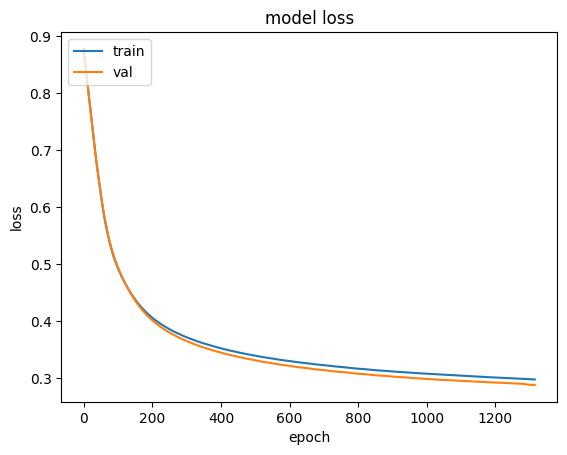

In [37]:
# смотрим график лосса (все норм)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We already see, that it took less time for model to finish training

In [38]:
y_pred_raw = model3.predict(X_test)
y_pred = np.around(y_pred_raw)
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1143
           1       0.72      0.91      0.80       357

    accuracy                           0.89      1500
   macro avg       0.84      0.90      0.86      1500
weighted avg       0.91      0.89      0.90      1500



# Conclusion

Unluckly SMOTE() made didn`t change Recall_1, but had negative impact on other metrics
:)